Tutorial:
http://deeplearning.net/tutorial/rbm.htm

In [9]:
import torchvision
import torch
import matplotlib.pyplot as plt
from torch import nn
import numpy as np
import torch.nn.functional as F
import time
from torchvision.utils import make_grid

data_dir = '/tmp'
train_batch_size = 64   # size of traning batch
num_visible = 784
num_hidden = 500
learning_rate = 0.01
max_epochs = 5

In [10]:
# Load mnist data
train_data = torch.utils.data.DataLoader(
torchvision.datasets.MNIST(data_dir, train=True, download=True,
                         transform=torchvision.transforms.Compose([
                           torchvision.transforms.ToTensor()
                         ])),
                        batch_size=train_batch_size, shuffle=True)


In [11]:
def show_data(data, ptile = (0,100)):
    # show grid of images
    # ptile: percentile range of intensity (min, max)
    img=make_grid(data)
    npimg = img.numpy()
    
    # normalize image to between 0 and 1
    imin = np.percentile(npimg, ptile[0])
    imax = np.percentile(npimg, ptile[1])
    npimg = (npimg-imin)/(imax-imin)
    
    vmin = np.percentile(npimg, ptile[0])
    vmax = np.percentile(npimg, ptile[1])
    #print(npimg.dtype, imin, imax, vmin, vmax)
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.axis('off')

In [12]:
class RBM(nn.Module):
    def __init__(self, num_visible, num_hidden, k = 1):
        '''
        numVisible: number of visible units
        numHidden: number of hidden units
        k: Number of Gibbs sampling in CD-k
        '''
        super(RBM, self).__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        
        torch.manual_seed(1234)
        low=-4 * np.sqrt(6. / (num_visible + num_hidden))
        high = 4 * np.sqrt(6. / (num_visible + num_hidden))
        self.W = nn.Parameter(low + torch.rand( (num_visible, num_hidden) ) * (high-low) )
        self.hbias = nn.Parameter(torch.zeros(num_hidden) )
        self.vbias = nn.Parameter(torch.zeros(num_visible) )
        self.k = k
        
    def forward(self, v0, k = None):
        '''
        CD-k  -- Use a training example to initalize Gibbs sampling, and do sampling k times
        '''
        if k == None:
            k = self.k
        v = v0
        for i in range(k):
            h, p_h = self.sample_h_given_v(v)
            v, p_v = self.sample_v_given_h(h)
        return v, p_v
    
    def sample_h_given_v(self, v):
        # Eq (7) sampling hidden variables p(h|v)
        p = torch.sigmoid( self.hbias + torch.mm(v, self.W))  # probability that v is 1
        return torch.bernoulli(p), p  # sample with Bernouli distribution
    
    def sample_v_given_h(self, h):
        # Eq (8) sampling visible variables p(v|h)
        p = torch.sigmoid(self.vbias + torch.mm(h, self.W.t())) # probability that h is 1
        return torch.bernoulli(p), p  # sample with Bernouli distribution
    
    def free_energy(self, v):
        # Eq (9) Free energy
        term1 = v.mv(self.vbias)
        term2 = torch.log(1.+torch.exp(self.hbias + torch.mm(v, self.W) )  ).sum(1)
        return - term1 -  term2

In [59]:
rbm = RBM(num_visible, num_hidden, k=50)
#optimizer = torch.optim.RMSprop(rbm.parameters(), lr=learning_rate, centered=True)
optimizer = torch.optim.RMSprop(rbm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(rbm.parameters(),lr=learning_rate)
time_start = time.time()
for epoch in range(max_epochs):
    loss_epoch = []
    for i,(images, label) in enumerate(train_data):
        rbm.zero_grad()
        v = images.reshape([-1,28*28])
        v0 = torch.bernoulli(v) # convert to binary data
        v1,_ = rbm(v0)
        loss = (rbm.free_energy(v0) - rbm.free_energy(v1)).mean()

        # backprop
        loss.backward()
        optimizer.step()
        loss_epoch.append(loss.detach().numpy())
    print(epoch, np.mean(loss_epoch), time.time()-time_start )    

0 15.045229 298.0717558860779
1 11.040263 587.0365874767303
2 11.162323 886.2950105667114
3 11.210642 1187.7552087306976
4 11.162959 1483.9362502098083


Training data as is:

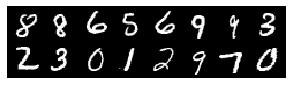

In [63]:
# training data
plt.figure(figsize=(5,20))
show_data(v[0:16].view(-1,1,28,28))

The larger the $k$ used in training, the longer Gibbs sampling sequence you can do yielding ligible digits:

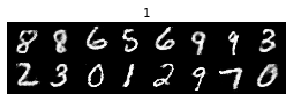

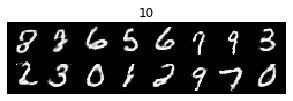

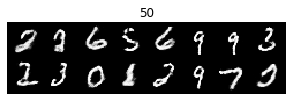

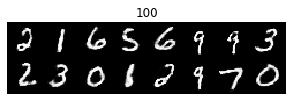

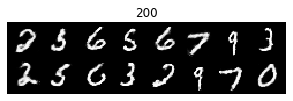

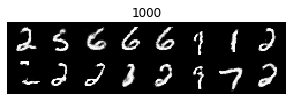

In [75]:
# generated data with different number of Gibbs sampling (average pv not sample v)
for k in [1,10,50,100, 200, 1000]:
    plt.figure(figsize=(5,20))
    _,pv = rbm(v,k)
    show_data(pv[0:16].detach().view(-1,1,28,28) )
    plt.title(str(k))

Visualize the weight matrix. The weights $W$ act like stoke filters that extract features from image and represent them as hidden variables. There are as many filters as number of hidden variables.  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


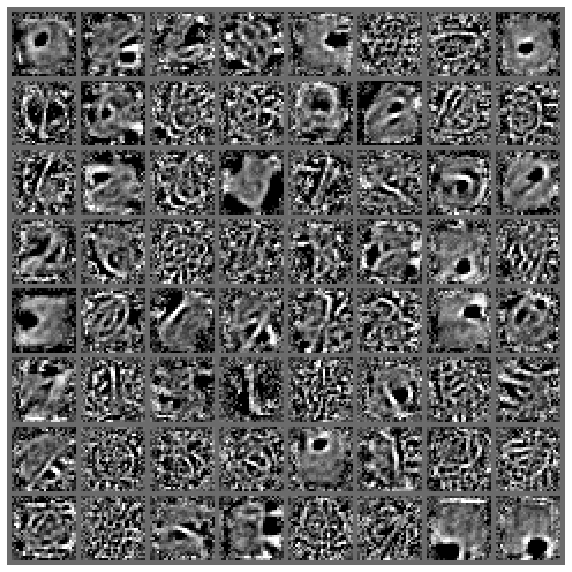

In [68]:
# plot learned weights (first 64)
W=rbm.W.view(28,28,1, num_hidden).clone().detach()
W = W.permute(3,2,0,1)
plt.figure(figsize=(10,20))
show_data(W[0:64], ptile=(10,99))

Random initialization does not generation good samples:

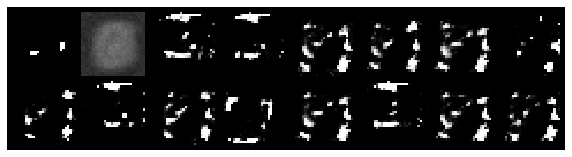

In [78]:
# Random initialization
k = 6000 # number of Gibbs sampling
r = torch.bernoulli(torch.rand(v.shape) )
plt.figure(figsize=(10,20))
vr, pr = rbm(r,k)
show_data(pr[0:16].detach().view(-1,1,28,28) )